In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [3]:
# For reproducibility
torch.manual_seed(42)

In [4]:
# -------------------------------
# 1. Load MNIST dataset
# -------------------------------

# Each MNIST image is 28x28 grayscale. We convert it to tensor and normalize.
transform = transforms.Compose([
    transforms.ToTensor(),                     # [0,255] -> [0,1]
    transforms.Normalize((0.5,), (0.5,))       # Normalize to mean 0, std 1
])

train_dataset = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=transform
)

test_dataset = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)


100%|██████████| 9.91M/9.91M [00:01<00:00, 6.08MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 160kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.52MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.82MB/s]


In [5]:
# -------------------------------
# 2. Define the Neural Network
#    Similar to your SimpleRegressor, but for 10 classes
# -------------------------------

class DigitClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),             # 1x28x28 -> 784
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10)         # 10 digits: 0–9 (logits, no softmax)
        )

    def forward(self, x):
        return self.net(x)


In [6]:
# -------------------------------
# 3. Training function (like your train_model)
# -------------------------------

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

def train_model(epochs=5, lr=1e-3):
    model = DigitClassifier().to(device)
    criterion = nn.CrossEntropyLoss()          # For classification
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    test_accuracies = []

    for epoch in range(epochs):
        # ---- Training loop ----
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward + optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)

        # ---- Evaluation on test set ----
        model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                # Get predicted class: index of max logit
                _, predicted = torch.max(outputs, dim=1)

                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = correct / total
        test_accuracies.append(accuracy)

        print(f"Epoch [{epoch+1}/{epochs}] - Loss: {epoch_loss:.4f} | "
              f"Test Accuracy: {accuracy*100:.2f}%")

    return model, train_losses, test_accuracies


Using device: cpu


Epoch [1/5] - Loss: 0.3906 | Test Accuracy: 92.65%
Epoch [2/5] - Loss: 0.1937 | Test Accuracy: 95.57%
Epoch [3/5] - Loss: 0.1355 | Test Accuracy: 96.12%
Epoch [4/5] - Loss: 0.1108 | Test Accuracy: 96.30%
Epoch [5/5] - Loss: 0.0942 | Test Accuracy: 96.37%


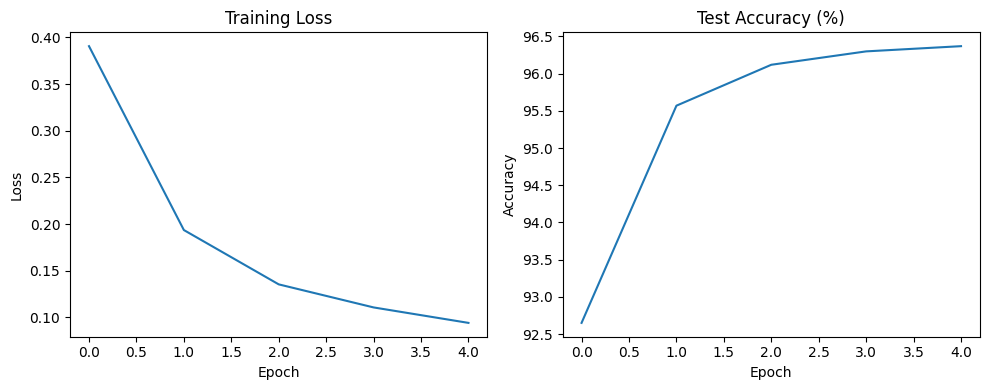

In [7]:

# -------------------------------
# 4. Train and Plot (like your regression example)
# -------------------------------

model, train_losses, test_accuracies = train_model(epochs=5)

plt.figure(figsize=(10, 4))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Plot test accuracy
plt.subplot(1, 2, 2)
plt.plot([acc * 100 for acc in test_accuracies])
plt.title("Test Accuracy (%)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.tight_layout()
plt.show()


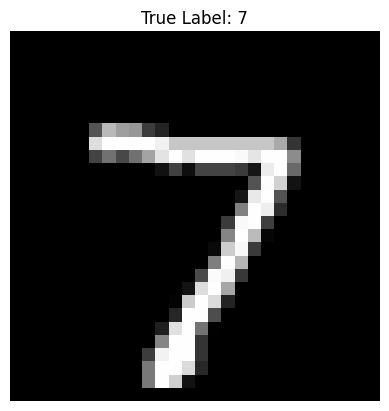

Model Prediction: 7


In [11]:
# -------------------------------
# 5. Test on a single image (optional)
# -------------------------------

# Take one sample from the test dataset
image, label = test_dataset[0]
plt.imshow(image.squeeze(), cmap="gray")
plt.title(f"True Label: {label}")
plt.axis("off")
plt.show()

model.eval()
with torch.no_grad():
    image = image.unsqueeze(0).to(device)   # add batch dimension
    output = model(image)
    predicted_class = output.argmax(dim=1).item()

print(f"Model Prediction: {predicted_class}")
